In [1]:
import torch
from transformers import BertForQuestionAnswering

In [2]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.config.max_position_embeddings = 2048

In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [4]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [5]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 70 tokens.


In [6]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102

bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
1             1,015
,             1,010
02            6,185
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
altogether   10,462
it            2,009
is            2,003
1             1,015
.             1,01

We've concatenated the question and answer_text together, but BERT still needs a way to distinguish them. BERT has two special "Segment" embeddings, one for segment "A" and one for segment "B". Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the question tokens, and the segment B embedding needs to be added to each of the answer_text tokens.
These additions are handled for us by the transformer library, and all we need to do is specify a '0' or '1' for each token.
Note: In the transformers library, huggingface likes to call these token_type_ids, but I'm going with segment_ids since this seems clearer, and is consistent with the BERT paper.

In [7]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [8]:
sep_index

10

In [9]:
num_seg_a

11

Side Note: Where's the padding?
The original example code does not perform any padding. I suspect that this is because we are only feeding in a single example. If we instead fed in a batch of examples, then we would need to pad or truncate all of the samples in the batch to a single length, and supply an attention mask to tell BERT to ignore the padding tokens.

## We're ready to feed our example into the model!

In [10]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text


## Now we can highlight the answer just by looking at the most probable start and end words.

In [11]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "340 ##m"


It got it right! Awesome :)
Side Note: It's a little naive to pick the highest scores for start and end--what if it predicts an end word that's before the start word?! The correct implementation is to pick the highest total score for which end >= start.
With a little more effort, we can reconstruct any words that got broken down into subwords.

In [12]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "340m"


I was curious to see what the scores were for all of the words. The following cells generate bar plots showing the start and end scores for every word in the input.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [14]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


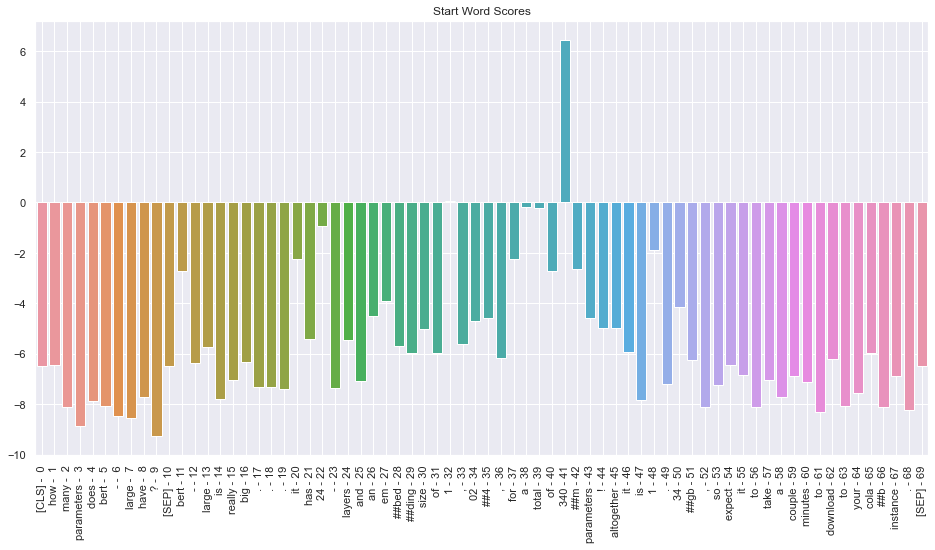

In [15]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

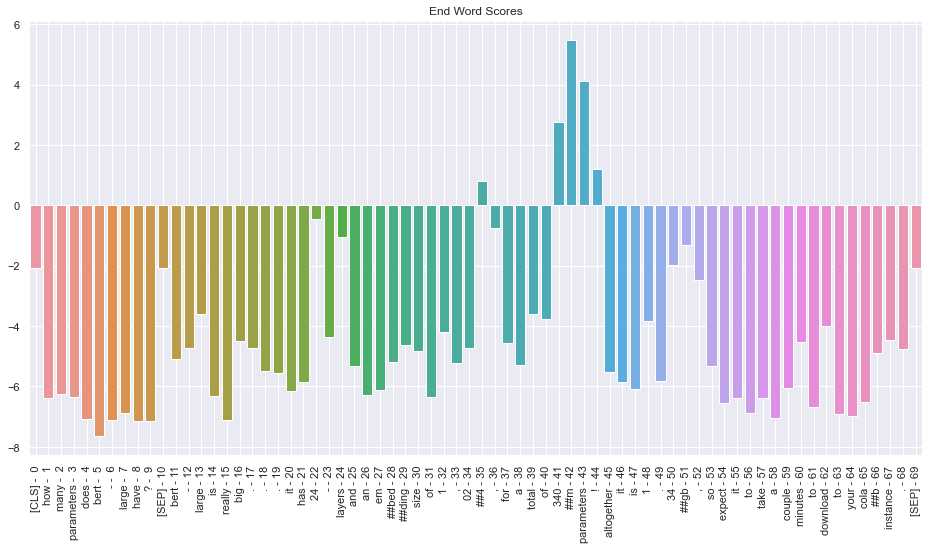

In [16]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

## Turn the QA process into a function so we can easily try out other examples.

In [17]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [18]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

In [19]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Query has 258 tokens.

Answer: "bidirectional encoder representations from transformers"


In [20]:
fin_doc = '''
AMENDMENT AND RESTATEMENT AGREEMENT
dated 4 June 2018


SAS AB (PUBL)
as Issuer and
INTERTRUST (SWEDEN) AB
as Agent


LEGAL#16574036v4
relating to the terms and conditions for the SEK 1,500,000,000 5.375 % fixed rate senior unsecured notes with ISIN SE0010520338 due 24 November 2022



This AMENDMENT AND RESTATEMENT AGREEMENT (this “Agreement”) is dated 4 June 2018 and made between:

(1) SAS AB (publ), Reg. No.556606-5499, a public limited liability company incorporated under the laws of Sweden (the “Issuer”); and

(2) INTERTRUST (SWEDEN) AB, Reg. No.556625-5476, a limited liability company incorporated under the laws of Sweden, acting for itself and as agent on behalf of the Noteholders (the “Agent”).

BACKGROUND

A. On 24 November 2017, the Issuer issued SEK 1,500,000,000 5.375 % fixed rate senior unsecured notes with ISIN SE0010520338 due 24 November 2022 (the “Notes”) constituted by terms and conditions dated 17 November 2018 (the “Terms and Conditions”).

B. On 22 May 2018 the Issuer resolved to undertake a tap issue of the Notes by way of offering and issuing up to SEK 1,000,000,000 in aggregate principal amount of Subsequent Notes.

C. On 29 May 2018 the Issuer resolved to enter into this Agreement and the transaction contemplated herein.

1. DEFINITIONS AND CONSTRUCTION

1.1 Definitions

“Dealer Agreement” means the dealer agreement dated 31 May 2018 and made between
(1) the Issuer, (2) Danske Bank A/S, Danmark, Sverige Filial, Nordea Bank AB (publ), Skandinaviska Enskilda Banken AB (publ) and Swedbank AB (publ) as joint lead managers and (3) Nordea Bank AB (publ) as issuing agent (the “Issuing Agent”).

“Effective Date” means the date on which the Issuing Agent notifies the Issuer that all conditions precedent under the Dealer Agreement have been satisfied or waived in accordance with the terms of the Dealer Agreement.

“Tap Issue” means the issuing of up to SEK 1,000,000,000 in aggregate principal amount of Subsequent Notes.

1.2 Construction

Unless otherwise defined in this Agreement, terms defined in the Terms and Conditions shall have the same meanings when used in this Agreement and the rules of construction set out in the Terms and Conditions shall apply also to this Agreement.

2. AMENDMENT AND RESTATEMENT

2.1 In accordance with clause 17(a)(i) of the Terms and Conditions, the Issuer and the Agent hereby agree that with effect from and including the Effective Date, the Terms and

Conditions shall be amended and restated in the form set out in Schedule 1 (Amended and Restated Terms and Conditions).

2.2 If the Effective Date has not occurred on or before 12 June 2018 this Agreement shall terminate automatically and be of no further force or effect.

2.3 Save as amended and restated by this Agreement, the Terms and Conditions shall remain in full force and effect.

3. NOTICES

Clause 23 (Notices and Press Releases) of the Terms and Conditions shall apply also to this Agreement.

4. LAW AND JURISDICTION

This Agreement is governed by and shall be construed in accordance with Swedish law and the provisions of Clause 25 (Governing Law and Jurisdiction) of the Terms and Conditions shall apply also to this Agreement.



SCHEDULE 1

AMENDED AND RESTATED TERMS AND CONDITIONS


Terms and Conditions

SAS AB (publ)
Senior Unsecured Fixed Rate SEK Notes 2017/2022

ISIN SE0010520338

Originally dated 20 November 2018, as amended and restated by an amendment and restatement agreement dated 4 June 2018

No action is being taken in any jurisdiction that would or is intended to permit a public offering of the Notes or the possession, circulation or distribution of any document or other material relating to the Issuer or the Notes in any jurisdiction other than Sweden, where action for that purpose is required. Each Noteholder must inform itself about, and observe, any applicable restrictions to the transfer of material relating to the Issuer or the Notes.


1. Table of Contents
1. DEFINITIONS AND CONSTRUCTION 1
2. AMENDMENT AND RESTATEMENT 1
3. NOTICES 2
4. LAW AND JURISDICTION 2
1. DEFINITIONS AND CONSTRUCTION 1
2. STATUS OF THE NOTES 7
3. USE OF PROCEEDS 8
4. TRANSFER RESTRICTIONS 8
5. NOTES IN BOOK-ENTRY FORM 8
6. RIGHT TO ACT ON BEHALF OF A NOTEHOLDER 9
7. PAYMENTS IN RESPECT OF THE NOTES 9
8. INTEREST 10
9. REDEMPTION AND REPURCHASE OF THE NOTES 11
10. INFORMATION TO NOTEHOLDERS 14
11. GENERAL UNDERTAKINGS 16
12. EVENTS OF DEFAULT AND ACCELERATION OF THE NOTES 18
13. DISTRIBUTION OF PROCEEDS 20
14. DECISIONS BY NOTEHOLDERS 21
15. NOTEHOLDERS' MEETING 24
16. WRITTEN PROCEDURE 25
17. AMENDMENTS AND WAIVERS 26
18. APPOINTMENT AND REPLACEMENT OF THE AGENT 26
19. APPOINTMENT AND REPLACEMENT OF THE ISSUING AGENT 30
20. APPOINTMENT AND REPLACEMENT OF THE CSD 30
21. NO DIRECT ACTIONS BY NOTEHOLDERS 30
22. PRESCRIPTION 31
23. NOTICES AND PRESS RELEASES 31
24. FORCE MAJEURE AND LIMITATION OF LIABILITY 32
25. GOVERNING LAW AND JURISDICTION 33

1. Definitions and Construction
1.1 Definitions

In these terms and conditions (the "Terms and Conditions"):

"Account Operator" means a bank or other party duly authorised to operate as an account operator pursuant to the Financial Instruments Accounts Act and through which a Noteholder has opened a Securities Account in respect of its Notes.

"Accounting Principles" means International financial reporting standards (IFRS) within the meaning of Regulation 1606/2002/EC (or as otherwise adopted or amended from time to time).

"Adjusted Nominal Amount" means the Total Nominal Amount, less the Nominal Amount of all Notes owned by a Group Company or an Affiliate, irrespective of whether such person is directly registered as owner of such Notes.

"Affiliate" means, in relation to any person, a Subsidiary of that person or a Holding Company of that person or any other Subsidiary of that Holding Company.

"Agency Agreement" means the agency agreement entered into on or before the First Issue Date, between the Issuer and the Agent, or any replacement agency agreement entered into after the First Issue Date between the Issuer and an agent.

"Agent" means Intertrust (Sweden) AB, Swedish Reg. No. 556625-5476, or another party replacing it, as Agent, in accordance with these Terms and Conditions.

"Business Day" means a day in Sweden other than a Sunday or other public holiday. Saturdays, Midsummer Eve (midsommarafton), Christmas Eve (julafton) and New Year's Eve (nyårsafton) shall for the purpose of this definition be deemed to be public holidays.

"Business Day Convention" means the first following day that is a Business Day. "Change of Control Event" means that:
(a) any person or group of persons (other than the Major Investors), acting in concert gains Control of the Issuer;

(b) all shares of the Issuer cease to be listed on a Regulated Market;

(c) the Issuer (directly or indirectly) cease to own hundred (100) per cent. of the participating shares in the SAS Consortium; or

(d) the SAS Consortium enters into a transaction or a series of transactions for the disposal of all or substantially all of its assets, directly or indirectly, to any person not being the Issuer or a Group Company wholly-owned (directly or indirectly) by the Issuer.

For this purpose, "Control" of the Issuer means:


(a) the power (whether by way of ownership of shares, proxy, contract, agency or otherwise) to directly or indirectly:

(i) cast, or control the casting of, more than fifty (50) per cent. of the maximum number of votes that might be cast at a general meeting of the shareholders of the Issuer; or

(ii) having the right to appoint or remove all, or the majority, of the directors or other equivalent officers of the Issuer; or

(b) the holding of more than fifty (50) per cent. of the issued share capital of the Issuer (excluding any part of that issued share capital that carries no right to participate beyond a specific amount in a distribution of either profits or capital).

For this purpose, "acting in concert" means, a group of persons who, pursuant to an agreement or understanding (whether formal or informal), actively co-operate, through the acquisition directly or indirectly of shares in the Issuer by any of them, either directly or indirectly, to obtain or consolidate control of the Issuer.

"CSD" means Euroclear Sweden AB, Swedish Reg. No. 556112-8074, P.O. Box 191, 101 23 Stockholm, Sweden or any other party replacing it as the Issuer's central securities depository and registrar in respect of the Notes, in accordance with these Terms and Conditions.

"CSD Regulations" means the CSD’s rules and regulations applicable to the Issuer, the Agent and the Notes from time to time.

"Event of Default" means an event or circumstance specified in Clause 1.1.1(a). "Final Maturity Date" means 24 November 2022.
"Finance Documents" means these Terms and Conditions, the Guarantee and any other document designated by the Issuer and the Agent as a Finance Document.

"Financial Indebtedness" means:

(a) moneys borrowed (including under any bank financing or Market Loans);

(b) the amount of any liability in respect of any lease which is treated as a balance sheet liability in accordance with the Accounting Principles (other than any liability in respect of a lease which would, in accordance with the Accounting Principles in force prior to 1 January 2019 have been treated as an operating lease);

(c) receivables sold or discounted (other than on a non-recourse basis, provided that the requirements for de-recognition under the Accounting Principles are met);

(d) any amount raised under any other transaction (including the obligation to pay deferred purchase price) having the commercial effect of a borrowing or otherwise being classified as borrowing under the Accounting Principles;


(e) the marked-to-market value of derivative transactions entered into in connection with protection against or benefit from fluctuation in any rate or price (if any actual amount is due as a result of a termination or a close-out, such amount shall be used instead);

(f) counter-indemnity obligations in respect of guarantees or other instruments issued by a bank or financial institution; and

(g) (without double counting) liabilities under guarantees or indemnities for any of the obligations referred to in paragraphs (a) to (f) above.

"Financial Instruments Accounts Act" means the Swedish Financial Instruments Accounts Act (lag (1998:1479) om värdepapperscentraler och kontoföring av finansiella instrument).

"First Call Date" means 24 November 2020. "First Issue Date" means 24 November 2017.
"Force Majeure Event" has the meaning set forth in Clause 1.1.1(a).

"Group" means the Issuer and its Subsidiaries (including the SAS Consortium) from time to time (each a "Group Company").

"Guarantee" means the guarantee (proprieborgen) issued by the SAS Consortium for the Issuer's payment obligations under the Notes and the Finance Documents (as documented in a separate guarantee agreement dated on or about the First Issue Date).

"Holding Company" means, in relation to a company or corporation, any other company or corporation in respect of which it is a Subsidiary.

"Initial Nominal Amount" has the meaning set forth in Clause 2(d). "Initial Notes" means the Notes issued on the First Issue Date.
"Insolvent" means, in respect of a relevant person, that it is deemed to be insolvent, or admits inability to pay its debts as they fall due, in each case within the meaning of Chapter 2, Sections 7-9 of the Swedish Bankruptcy Act (konkurslagen (1987:672)) (or its equivalent in any other jurisdiction), suspends making payments on any of its debts or by reason of actual financial difficulties commences negotiations with its creditors (other than the Noteholders) with a view to rescheduling any of its indebtedness (including company reorganisation under the Swedish Company Reorganisation Act (lag (1996:764) om företagsrekonstruktion) (or its equivalent in any other jurisdiction)) or is subject to involuntary winding-up, dissolution or liquidation (other than any winding- up, dissolution or liquidation commenced as a result of a petition which is frivolous or vexatious or which is contested on bona fide grounds, which in either case is discharged, stayed or dismissed with 30 Business Days of commencement).

"Interest" means the interest on the Notes calculated in accordance with Clauses 1.1.1(a) to 1.1.1(c).


"Interest Payment Date" means 24 November of each year or, to the extent such day is not a Business Day, the Business Day following from an application of the Business Day Convention. The first Interest Payment Date for the Notes shall be 24 November 2018 and the last Interest Payment Date shall be the relevant Redemption Date.

"Interest Period" means (i) in respect of the first Interest Period, the period from (but excluding) the First Issue Date to (and including) the first Interest Payment Date, and (ii) in respect of subsequent Interest Periods, the period from (but excluding) an Interest Payment Date to (and including) the next succeeding Interest Payment Date (or a shorter period if relevant). An Interest Period shall not be adjusted due to an application of the Business Day Convention.

"Interest Rate" means 5.375 per cent. per annum.

"Issuer" means SAS AB (publ), a public limited liability company incorporated under the laws of Sweden, with company registration number 556606-8499.

"Issuing Agent" means Nordea Bank AB (publ), or another party replacing it, as Issuing Agent, in accordance with these Terms and Conditions and the CSD Regulations.

"Listing Failure Event" means (i) that the Notes are not registered and admitted to trading on Nasdaq Stockholm or another Regulated Market within sixty (60) calendar days after the First Issue Date, or (ii) that a de-listing is made to the contrary of Clause 1.1.1(c).

"Major Investor" means each of (i) the Swedish government, (ii) the Norwegian government, (iii) the Danish government, (iv) Knut and Alice Wallenberg's foundation, a foundation registered in Sweden, with Swedish Reg. No. 802005-9773 and (v) any person under the direct or indirect control of one or more of the persons mentioned under sub-paragraphs (i)-(iv) above.

"Market Loan" means any loan or other indebtedness where an entity issues subordinated debentures, bonds or any other debt securities (including, for the avoidance of doubt, medium term note programmes and other market funding programmes), provided in each case that such instruments and securities are, or can be, quoted, registered and/or admitted to trading on a Regulated Market or on any unregulated recognised market place.

"Material Group Company" means the Issuer, the SAS Consortium or any other Group Company representing more than five (5) per cent. of the Total Assets according to the latest consolidated audited annual financial statements of the Group.

"Moody's" means Moody's Investors Service Ltd.

"Net Disposal Proceeds" means the proceeds received in cash from any disposal less any costs relating to the disposal, any fees and any tax relating to the disposal.

"Nominal Amount" means in respect of each Note the Initial Nominal Amount, less the aggregate amount by which that Note has been redeemed in part.


"Noteholder" means the person who is registered on a Securities Account as direct registered owner (ägare) or nominee (förvaltare) with respect to a Note.

"Noteholders' Meeting" means a meeting among the Noteholders held in accordance with Clause 15 (Noteholders' Meeting).

"Note" means a debt instrument (skuldförbindelse) for the Nominal Amount and of the type set forth in Chapter 1 Section 3 of the Financial Instruments Accounts Act and which are governed by and issued under these Terms and Conditions, including the Initial Notes and any Subsequent Notes.

"Record Date" means the fifth (5) Business Day prior to (i) an Interest Payment Date, (ii) a Redemption Date, (iii) a date on which a payment to the Noteholders is to be made under Clause 13 (Distribution of Proceeds) or (v) another relevant date, or in each case such other Business Day falling prior to a relevant date if generally applicable on the Swedish bond market.

"Redemption Date" means the date on which the relevant Notes are to be redeemed or repurchased in accordance with Clause 9 (Redemption and Repurchase of the Notes).

"Regulated Market" means any regulated market (as defined in Directive 2004/39/EC on markets in financial instruments).

"Restricted Disposal" means a sale or other disposal of (i) all shares or other ownership interests (including by merger or demerger, as applicable) in any Material Group Company or (ii) all or substantially all of a Material Group Company's (other than SAS Consortium's) assets or operations, in each case to any person not being the Issuer or a Group Company wholly owned (directly or indirectly) by the Issuer.

"SAS Consortium" means Scandinavian Airlines System Denmark – Norway – Sweden.

"Securities Account" means the account for dematerialised securities maintained by the CSD pursuant to the Financial Instruments Accounts Act in which (i) an owner of such security is directly registered or (ii) an owner's holding of securities is registered in the name of a nominee.

"Security" means a mortgage, charge, pledge, lien, security assignment or other security interest securing any obligation of any person, or any other agreement or arrangement having a similar effect.

"Standard & Poor" means Standard & Poor's Financial Services LLC.

"Subsequent Notes" means any Notes issued after the First Issue Date on one or more occasions.

"Subsidiary" means, in relation to any person, any Swedish or foreign legal entity (whether incorporated or not), in respect of which such person, directly or indirectly, (i) owns shares or ownership rights representing more than fifty (50) per cent. of the total number of votes held by the owners, (ii) otherwise controls more than fifty (50) per cent. of the total number of votes held by the owners or (iii) has the power to appoint and


remove all, or the majority of, the members of the board of directors or other governing body.

"Swedish Government Bond Rate" means direct obligations of Sweden (statsobligationer) with a fixed maturity equal to the period from the Redemption Date to the First Call Date, provided that if the period from the Redemption Date to the First Call Date:

(a) is not equal to the fixed maturity of a direct obligation of Sweden for which a weekly average yield is given, the Swedish Government Bond Rate shall be obtained by linear interpolation from the weekly average yields of direct obligations of Sweden for which such yields are given; and

(b) is less than one (1) year, the weekly average yield on actually traded direct obligations of Sweden adjusted to a fixed maturity of one year shall be used.

'''

In [21]:
print(wrapper.fill(fin_doc))

 AMENDMENT AND RESTATEMENT AGREEMENT dated 4 June 2018   SAS AB (PUBL) as Issuer
and INTERTRUST (SWEDEN) AB as Agent   LEGAL#16574036v4 relating to the terms and
conditions for the SEK 1,500,000,000 5.375 % fixed rate senior unsecured notes
with ISIN SE0010520338 due 24 November 2022    This AMENDMENT AND RESTATEMENT
AGREEMENT (this “Agreement”) is dated 4 June 2018 and made between:  (1) SAS AB
(publ), Reg. No.556606-5499, a public limited liability company incorporated
under the laws of Sweden (the “Issuer”); and  (2) INTERTRUST (SWEDEN) AB, Reg.
No.556625-5476, a limited liability company incorporated under the laws of
Sweden, acting for itself and as agent on behalf of the Noteholders (the
“Agent”).  BACKGROUND  A. On 24 November 2017, the Issuer issued SEK
1,500,000,000 5.375 % fixed rate senior unsecured notes with ISIN SE0010520338
due 24 November 2022 (the “Notes”) constituted by terms and conditions dated 17
November 2018 (the “Terms and Conditions”).  B. On 22 May 2018 the Is